# CAPSTONE 350

In [154]:
import requests
import os
from datetime import datetime
import findspark
findspark.init() 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat, initcap, lit, lower, substring, when, coalesce, expr, length, to_date, lpad, concat_ws
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType
import pandas as pd 
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
 

# 1. Functional Requirements - Load Credit Card Database (SQL)

In [155]:
schema_customers = StructType([
                            StructField("SSN", IntegerType(), False),
                            StructField("FIRST_NAME", StringType()),
                            StructField("MIDDLE_NAME", StringType()),
                            StructField("LAST_NAME", StringType()),
                            StructField("CREDIT_CARD_NO", StringType()),
                            StructField("APT_NO", StringType()),
                            StructField("STREET_NAME", StringType()),
                            StructField("CUST_CITY", StringType()),
                            StructField("CUST_STATE", StringType()),
                            StructField("CUST_COUNTRY", StringType()),
                            StructField("CUST_ZIP", StringType()),
                            StructField("CUST_PHONE", StringType()),
                            StructField("CUST_EMAIL", StringType()),
                            StructField("LAST_UPDATED", TimestampType())
])

schema_branches = StructType([
                            StructField("BRANCH_CODE", IntegerType(), False),
                            StructField("BRANCH_NAME", StringType()), 
                            StructField("BRANCH_STREET", StringType()),
                            StructField("BRANCH_CITY", StringType()),
                            StructField("BRANCH_STATE", StringType()),
                            StructField("BRANCH_ZIP", StringType()),
                            StructField("BRANCH_PHONE", StringType()),
                            StructField("LAST_UPDATED", TimestampType())
])


schema_cc_transactions = StructType([
                            StructField("CREDIT_CARD_NO", StringType()),
                            StructField("DAY", IntegerType()),
                            StructField("MONTH", IntegerType()),
                            StructField("YEAR", IntegerType()),
                            StructField("CUST_SSN", StringType()),
                            StructField("BRANCH_CODE", IntegerType()),
                            StructField("TRANSACTION_TYPE", StringType()),
                            StructField("TRANSACTION_VALUE", FloatType()),
                            StructField("TRANSACTION_ID", IntegerType(), False)
])

schema_loans = StructType([
                            StructField("Application_ID", StringType()),
                            StructField("Gender", StringType()),
                            StructField("Married", StringType()),
                            StructField("Dependents", StringType()),
                            StructField("Education", StringType()),
                            StructField("Self_Employed", StringType()),
                            StructField("Credit_History", StringType()),
                            StructField("Property_Area", StringType()),
                            StructField("Income", StringType()),
                            StructField("Application_Status", StringType())
])


## 1.1 Data Extraction and Transformation

In [156]:
# 1.1 Extact (Branch, Customer, and Credit Card) data into Spark Dataframes

spark = SparkSession.builder.appName("credit_card").getOrCreate()

df_customers = spark.read.json("cdw_sapp_customer.json", schema=schema_customers)
df_customers.show(5)

df_branches = spark.read.json("cdw_sapp_branch.json", schema=schema_branches)
df_branches.show(5)

df_cc = spark.read.json("cdw_sapp_credit.json", schema=schema_cc_transactions)
df_cc.show(5)

+---------+----------+-----------+---------+----------------+------+-----------------+------------+----------+-------------+--------+----------+-------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO|APT_NO|      STREET_NAME|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+------+-----------------+------------+----------+-------------+--------+----------+-------------------+-------------------+
|123456100|      Alec|         Wm|   Hooper|4210653310061055|   656|Main Street North|     Natchez|        MS|United States|   39120|   1237818|AHooper@example.com|2018-04-21 09:49:02|
|123453023|      Etta|    Brendan|   Holman|4210653310102868|   829|    Redwood Drive|Wethersfield|        CT|United States|   06109|   1238933|EHolman@example.com|2018-04-21 09:49:02|
|123454487|    Wilber|   Ezequiel|   Dunham|4210653310116272|   683| 12th S

In [157]:
# 1.1.1 Transform "Customer" Data according to Mapping Document

df_customer_trans = df_customers.withColumn("FIRST_NAME", initcap(col("FIRST_NAME"))) \
                                .withColumn("MIDDLE_NAME",lower(col("MIDDLE_NAME"))) \
                                .withColumn("LAST_NAME", initcap(col("LAST_NAME"))) \
                                .withColumn("FULL_STREET_ADDRESS", concat(col("APT_NO"), lit(","),col("STREET_NAME"))) \
                                .withColumn("CUST_PHONE", 
                                            concat(
                                                    lit("(123)"),
                                                    substring(col("CUST_PHONE"), 1, 3),
                                                    lit("-"),
                                                    substring(col("CUST_PHONE"), 4, 4)
                                                    )) \
                                .withColumn("SSN", col("SSN").cast("int")) \
                                .withColumn("CUST_ZIP", col("CUST_ZIP").cast("int")) \
                                .withColumn("LAST_UPDATED", col("LAST_UPDATED").cast("timestamp"))
                                
# Rearranging "Customer" columns

cust_cols = ["SSN", "FIRST_NAME", "MIDDLE_NAME", "LAST_NAME", "CREDIT_CARD_NO", "FULL_STREET_ADDRESS",
                "CUST_CITY", "CUST_STATE", "CUST_COUNTRY", "CUST_ZIP","CUST_PHONE", "CUST_EMAIL" , "LAST_UPDATED"]

df_customer_trans = df_customer_trans.select(cust_cols)                                                               
df_customer_trans.show()

+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+--------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|          CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+--------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|656,Main Street N...|     Natchez|        MS|United States|   39120|(123)123-7818| AHooper@example.com|2018-04-21 09:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|   829,Redwood Drive|Wethersfield|        CT|United States|    6109|(123)123-8933| EHolman@example.com|2018-04-21 09:49:02|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|683,12th Stree

In [158]:
# 1.1.2 Transform Branch Data according to Mapping Document

df_branches_trans = df_branches.withColumn("BRANCH_ZIP", when(col("BRANCH_ZIP").isNull(), 99999).otherwise(col("BRANCH_ZIP"))) \
                              .withColumn("BRANCH_PHONE", 
                                      concat(
                                            lit("("),
                                            substring(col("BRANCH_PHONE"), 0, 3),
                                            lit(")"),
                                            substring(col("BRANCH_PHONE"), 4, 3),
                                            lit("-"),
                                            substring(col("BRANCH_PHONE"), 7, 4)
                                             ))

df_branches_trans.show(5)



+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|BRANCH_CODE| BRANCH_NAME|    BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|       LAST_UPDATED|
+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|          1|Example Bank|     Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|2018-04-18 13:51:47|
|          2|Example Bank|Washington Street|          Huntley|          IL|     60142|(123)461-8993|2018-04-18 13:51:47|
|          3|Example Bank|    Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|2018-04-18 13:51:47|
|          4|Example Bank| Cleveland Street|       Middleburg|          FL|     32068|(123)466-3064|2018-04-18 13:51:47|
|          5|Example Bank|      14th Street|    KingOfPrussia|          PA|     19406|(123)484-9701|2018-04-18 13:51:47|
+-----------+------------+------

In [159]:
# 1.1.3 Transform Credit Card Data according to Mapping Docuement

df_cc_trans = df_cc.withColumn("DAY", concat("YEAR", lpad("MONTH", 2, '0'), lpad("DAY", 2, '0')))\
                                        .withColumnRenamed("DAY","TIMEID")\
                                        .drop("MONTH")\
                                        .drop("YEAR")
                                        
df_cc_trans.show()

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|  CREDIT_CARD_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|
|4210653349028689|20180528|123459988|        164|       Education|             6.89|             6|
|4210653349028689|20180519|123459988|        119|   Entertainment|            43.39|             7|


## 1.2 Data loading into Database

In [160]:
df_customer_trans.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "cdw_sapp_customer") \
  .option("user", "root") \
  .option("password", "password") \
  .save()
  
df_branches_trans.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "cdw_sapp_branches") \
  .option("user", "root") \
  .option("password", "password") \
  .save()
  
df_cc_trans.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "cdw_sapp_credit_card") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

## 3. Data Anaylysis and Visualization

In [161]:
import pandas as pd
import pymysql

def query_db(query, printable=True):
    try:
        user = "root"
        password = "password"
        host = "localhost"
        port = 3306
        database = "creditcard_capstone"
        
        # Establish a connection to MySQL database
        connection = pymysql.connect(
            host=host,
            port=port,
            user=user,
            password=password,
            database=database
        )

        # Create a cursor object
        cursor = connection.cursor()

        # Execute the SQL query
        cursor.execute(query)

        # Fetch the result into a Pandas DataFrame
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=[i[0] for i in cursor.description])

        # Close the cursor and the database connection
        cursor.close()
        connection.close()

        if not df.empty:
            return df
        else:
            print("EMPTY DATAFRAME")

    except Exception as e:
        print(f"ERROR connecting to Local database: {e}")

# Example usage:
query = "SELECT * FROM cdw_sapp_credit_card"
result = query_db(query)
print(result)

         CREDIT_CARD_NO    TIMEID   CUST_SSN  BRANCH_CODE TRANSACTION_TYPE   
0      4210653312478046  20180813  123455692          156          Grocery  \
1      4210653342242023  20180315  123451310          180            Bills   
2      4210653342242023  20180419  123451310          107       Healthcare   
3      4210653312478046  20180626  123455692          114            Bills   
4      4210653342242023  20180628  123451310           58       Healthcare   
...                 ...       ...        ...          ...              ...   
46689  4210653312478046  20180602  123455692          131          Grocery   
46690  4210653312478046  20180216  123455692          158            Bills   
46691  4210653312478046  20180615  123455692           20       Healthcare   
46692  4210653312478046  20181217  123455692           80        Education   
46693  4210653312478046  20180619  123455692           91             Test   

       TRANSACTION_VALUE  TRANSACTION_ID  
0                  9

Find which transaction type has the highest transaction count.

In [162]:
query = "SELECT transaction_type, count(*) as count from cdw_sapp_credit_card GROUP BY transaction_type"
df_cc = query_db(query, False)
df_cc.set_index(df_cc.columns[0], inplace=True)

df_cc

,count
transaction_type,
Grocery,6549
Bills,6861
Healthcare,6723
Education,6638
Gas,6605
Entertainment,6635
Test,6683


3.1 Plot which transaction type has the highest transaction count.

Text(0, 0.5, 'Number of Transactions')

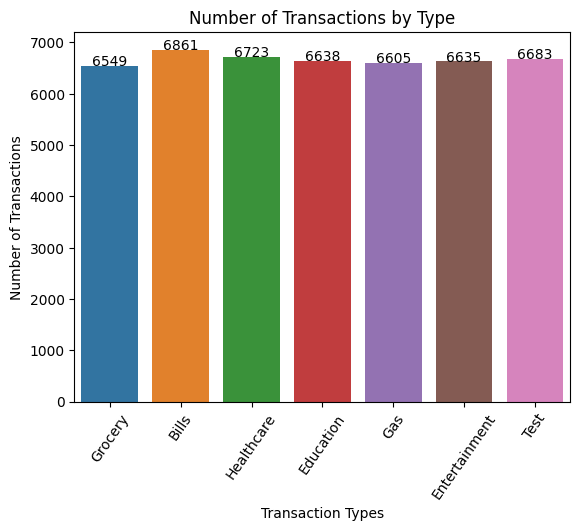

In [163]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center')

#df_cc_trans = query_db("SELECT * FROM cdw_sapp_credit_card", False)
sns.barplot(x=df_cc.index, y="count", data=df_cc)
plt.xticks(rotation=55)
addlabels(df_cc.index, df_cc["count"])
plt.title("Number of Transactions by Type")
plt.xlabel("Transaction Types")
plt.ylabel("Number of Transactions")

3.2a Find which state(s) has high(est) number of customers

In [164]:
df_cust = query_db("SELECT cust_state, count(*) count FROM cdw_sapp_customer GROUP BY cust_state ORDER BY count desc", False)
df_cust

,cust_state,count
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58
5,NJ,53
6,MD,50
7,CA,45
8,OH,44
9,MI,44


3.2b Plot which state(s) has high(est) number of customers

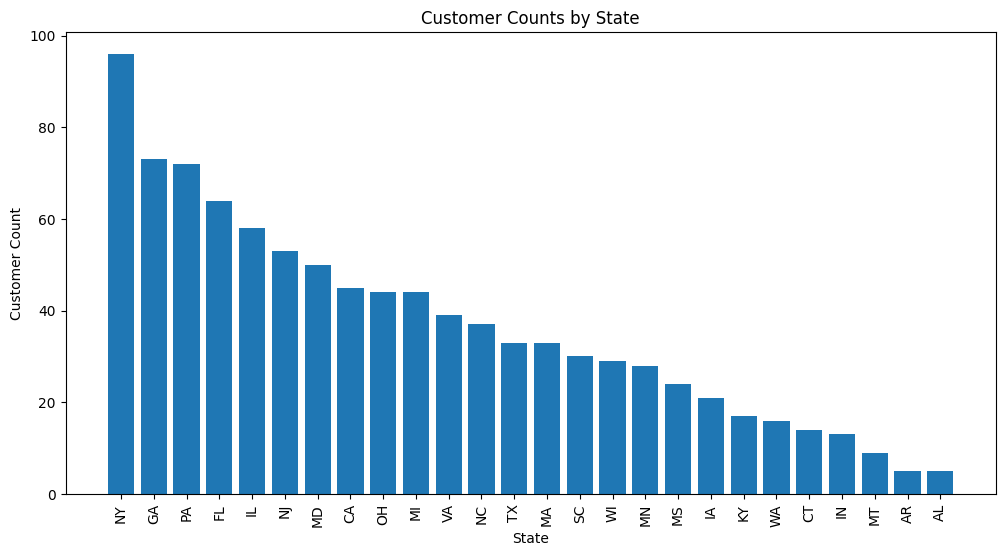

In [165]:

plt.figure(figsize=(12, 6))  # Optional: Set the figure size
plt.bar(df_cust['cust_state'], df_cust['count'])
plt.title("Customer Counts by State")
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.show()


3.3a Find the sum of all transaction for the top 10 customers, 
and which customer has the highest transaction amount

In [166]:
query = """
SELECT CONCAT(first_name, ' ', middle_name, ' ', last_name) AS full_name, 
       SUM(transaction_value) AS Total
FROM cdw_sapp_credit_card cc
JOIN cdw_sapp_customer c ON cc.CREDIT_CARD_NO = c.CREDIT_CARD_NO
GROUP BY full_name
ORDER BY Total DESC
LIMIT 10
"""

df_top_10_cc = query_db(query, False)
df_top_10_cc

,full_name,Total
0,Ty leticia Daly,5633.070010
1,Jessie selma Boucher,5548.140002
2,Phoebe ali Martin,5476.080026
3,Thurman granville Vera,5314.970028
4,Bret margarita Perkins,5261.030018
5,Joesph eula Mcclain,5241.180026
6,Aurelia pearlie Haas,5223.960013
7,Marcelo gonzalo Emerson,5203.080009
8,Alexis lorene Villarreal,5149.749994
9,Christina lyle Snow,5133.290017


3.3b Plot the sum of all transaction for the top 10 customers, 
and which customer has the highest transaction amount

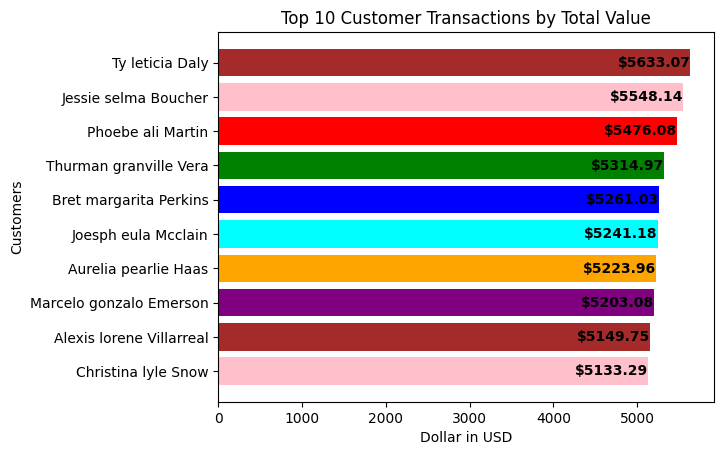

In [167]:
import matplotlib.pyplot as plt

my_colors = ['brown','pink', 'red', 'green', 'blue', 'cyan','orange','purple']

# Set the index to 'full_name' for plotting
df_top_10_cc2 = df_top_10_cc.set_index("full_name")

# Create the horizontal bar chart
p = plt.barh(df_top_10_cc2.index, df_top_10_cc2['Total'], color=my_colors)

# Loop to add total values as labels to each bar
for i, v in enumerate(df_top_10_cc2['Total']):
    #plt.text(v, i, f"${v:.2f}", fontweight='bold', va='center')
    plt.text(v, i, f"${v:.2f}", fontweight='bold', va='center', ha='left' if v < 0 else 'right')


plt.ylim(plt.ylim()[::-1])
plt.title("Top 10 Customer Transactions by Total Value")
plt.ylabel("Customers")
plt.xlabel("Dollar in USD")
plt.show()



## 4. Access to Loan API Endpoint

In [168]:
schema_loans = StructType([
                            StructField("Application_ID", StringType()),
                            StructField("Gender", StringType()),
                            StructField("Married", StringType()),
                            StructField("Dependents", StringType()),
                            StructField("Education", StringType()),
                            StructField("Self_Employed", StringType()),
                            StructField("Credit_History", StringType()),
                            StructField("Property_Area", StringType()),
                            StructField("Income", StringType()),
                            StructField("Application_Status", StringType())])

In [169]:
# 4.1 Create a Python to GET (consume) data from the API endpoint for the load application

resp = requests.get("https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json")
df_loan = spark.createDataFrame(resp.json(), schema=schema_loans)
df_loan.show(5)

+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|   Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|      LP001002|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|
|      LP001003|  Male|    Yes|         1|    Graduate|           No|             1|        Rural|medium|                 N|
|      LP001005|  Male|    Yes|         0|    Graduate|          Yes|             1|        Urban|   low|                 Y|
|      LP001006|  Male|    Yes|         0|Not Graduate|           No|             1|        Urban|   low|                 Y|
|      LP001008|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|


In [170]:
# 4.2 Find the status code of Loan API

if resp.status_code == 200:
    print("API request was successful. Status code:", resp.status_code)
else:
    print("API request failed. Status code:", resp.status_code)


API request was successful. Status code: 200


In [171]:
# 4.3 Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL). 
# The table name should be CDW-SAPP_loan_application in the database

spark = SparkSession.builder.appName("loan").getOrCreate()

df_loan = spark.createDataFrame(resp.json(), schema=schema_loans)
df_loan.show(5)

df_loan.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "cdw_sapp_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|   Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|      LP001002|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|
|      LP001003|  Male|    Yes|         1|    Graduate|           No|             1|        Rural|medium|                 N|
|      LP001005|  Male|    Yes|         0|    Graduate|          Yes|             1|        Urban|   low|                 Y|
|      LP001006|  Male|    Yes|         0|Not Graduate|           No|             1|        Urban|   low|                 Y|
|      LP001008|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|


## 5: Data Analysis and Visualization for LOAN Application

In [172]:
# Open and read the .secrets.txt file
with open(".secrets.txt", "r") as f:
    secrets = f.read().splitlines()

# Initialize variables for user and password
user = None
password = None

# Parse the secrets
for line in secrets:
    key, value = line.split("=")
    if key == "user":
        user = value
    elif key == "password":
        password = value

# Check if user and password have been obtained
if user is not None and password is not None:
    df_loan.write.format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("dbtable", "cdw_sapp_loan_application") \
        .option("user", user) \
        .option("password", password) \
        .save()
else:
    print("User and/or password not found in .secrets.txt")

In [173]:
import pandas as pd
import pymysql

def query_db(query, printable=True):
    try:
        user = "root"
        password = "password"
        host = "localhost"
        port = 3306
        database = "creditcard_capstone"
        
        # Establish a connection to MySQL database
        connection = pymysql.connect(
            host=host,
            port=port,
            user=user,
            password=password,
            database=database
        )

        # Create a cursor object
        cursor = connection.cursor()

        # Execute the SQL query
        cursor.execute(query)

        # Fetch the result into a Pandas DataFrame
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=[i[0] for i in cursor.description])

        # Close the cursor and the database connection
        cursor.close()
        connection.close()

        if not df.empty:
            return df
        else:
            print("EMPTY DATAFRAME")

    except Exception as e:
        print(f"ERROR connecting to Local database: {e}")

# Example usage:
query = "SELECT * FROM cdw_sapp_loan_application"
result = query_db(query)
print(result)



    Application_ID  Gender Married Dependents     Education Self_Employed   
0         LP001953    Male     Yes          1      Graduate            No  \
1         LP002448    Male     Yes          0      Graduate            No   
2         LP001245    Male     Yes          2  Not Graduate           Yes   
3         LP001954  Female     Yes          1      Graduate            No   
4         LP001248    Male      No          0      Graduate            No   
..             ...     ...     ...        ...           ...           ...   
506       LP001720    Male     Yes         3+  Not Graduate            No   
507       LP001722    Male     Yes          0      Graduate            No   
508       LP001726    Male     Yes          0      Graduate            No   
509       LP001736    Male     Yes          0      Graduate            No   
510       LP001743    Male     Yes          2      Graduate            No   

    Credit_History Property_Area  Income Application_Status  
0            

5.1 Find and plot the percentage of applications approved for self-employeed applicants

Text(0, 0.5, '')

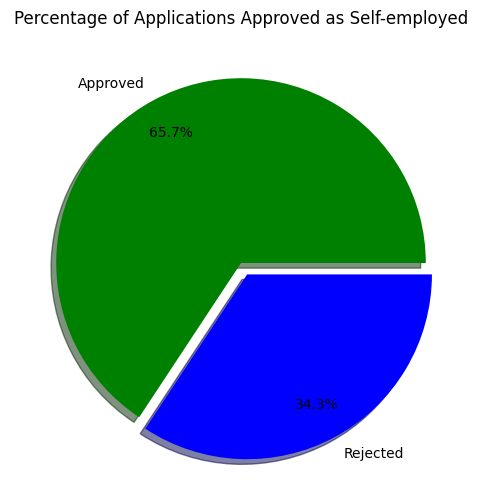

In [174]:
query = "SELECT application_status, count(application_status) as count FROM cdw_sapp_loan_application WHERE self_employed='Yes' GROUP BY application_status;"    

df_self_emp = query_db(query, False)
df_self_emp = df_self_emp.replace(['Y'], 'Approved').replace(['N'], 'Rejected')
df_self_emp = df_self_emp.set_index(df_self_emp.columns[0])

df_self_emp.head()

df_self_emp["count"].plot(kind='pie',
                    figsize=(15,6),
                    autopct='%1.1f%%',
                    shadow=True,
                    pctdistance=.80,
                    colors=('green','blue'),
                    explode=[0, 0.07])

plt.title("Percentage of Applications Approved as Self-employed")
plt.ylabel('')               

5.2 Find the percentage of rejection for married male applicants

Text(0, 0.5, '')

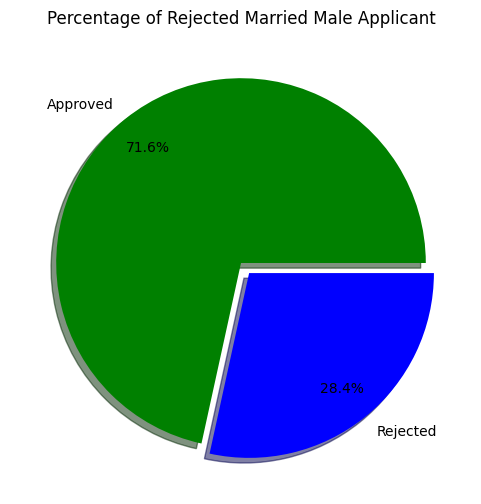

In [175]:
query = "SELECT application_status, count(*) as count FROM cdw_sapp_loan_application WHERE married = 'Yes' AND gender = 'Male' \
                        GROUP BY application_status"
df_married_male = query_db(query)
df_married_male = df_married_male.replace(['Y'], 'Approved').replace(['N'], 'Rejected') 
df_married_male = df_married_male.set_index(df_married_male.columns[0])

df_married_male.head()

df_married_male["count"].plot(kind='pie',
                    figsize=(15,6),
                    autopct='%1.1f%%',
                    shadow=True,
                    pctdistance=.80,
                    colors=('green','blue'),
                    explode=[0, 0.07])

plt.title("Percentage of Rejected Married Male Applicant")
plt.ylabel('')  

5.3 Find and plot the top three months with the largest volume of transactions data.

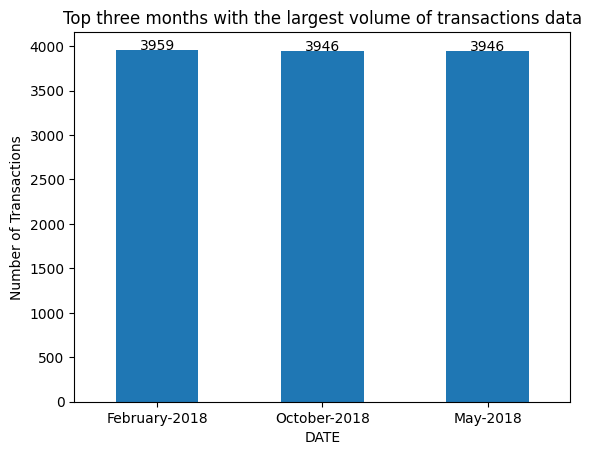

In [176]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center')

query ="SELECT CONCAT( DATE_FORMAT(DATE(timeid),'%M'),'-', YEAR(DATE(timeid)) ) date, count(*) count  \
                                 FROM cdw_sapp_credit_card \
                                 GROUP BY 1 \
                                 ORDER BY count desc \
                                 LIMIT 3"
                                 
df_top_3_months_trans = query_db(query)
    
df_top_3_months_trans.set_index("date", inplace=True)
df_top_3_months_trans.plot(kind='bar', legend=False)
plt.title("Top three months with the largest volume of transactions data")
plt.xlabel("DATE")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
addlabels(df_top_3_months_trans.index, df_top_3_months_trans['count'])

5.4 Find and plot which branch processed the highest total dollar value of healthcare transactions

   BRANCH_CODE        total
0           25  4370.180008
1           60  4072.039993
2           83  4003.370006
3           36  3823.869989
4          111  3720.269999
5           90  3697.160005
6           21  3651.740012
7          109  3603.670005
8           42  3603.250011
9           70  3594.350014


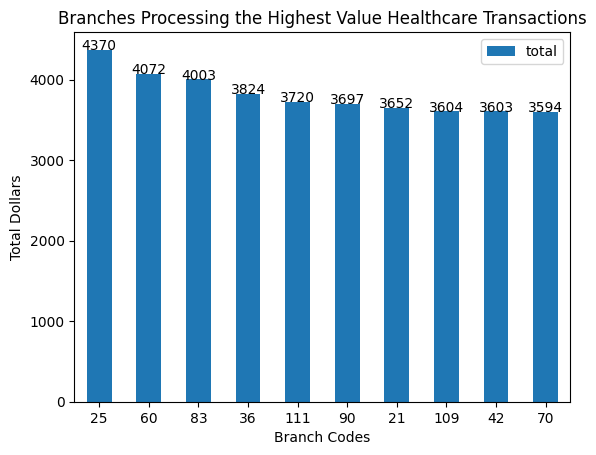

In [178]:

query = "SELECT b.BRANCH_CODE, sum(transaction_value) as total FROM cdw_sapp_credit_card cc \
                                JOIN cdw_sapp_branches b \
                                    ON cc.BRANCH_CODE = b.BRANCH_CODE \
                                WHERE TRANSACTION_TYPE = 'Healthcare' \
                                GROUP BY b.branch_code \
                                ORDER BY 2 desc \
                                LIMIT 10"
df_branch_highest_healthcare = query_db(query)

print(df_branch_highest_healthcare)


# Assuming df_branch_highest_healthcare has duplicates and you want to remove them
#df_branch_highest_healthcare = df_branch_highest_healthcare.drop_duplicates()

# Plot the cleaned DataFrame
ax = df_branch_highest_healthcare.plot(kind="bar", x='BRANCH_CODE', y='total')
plt.title("Branches Processing the Highest Value Healthcare Transactions")
plt.xlabel("Branch Codes")
plt.ylabel("Total Dollars")

# Set the x-tick labels to branch codes
ax.set_xticklabels(df_branch_highest_healthcare['BRANCH_CODE'])

plt.xticks(rotation=0)
addlabels(df_branch_highest_healthcare.index, df_branch_highest_healthcare["total"].round().astype(int))
plt.show()

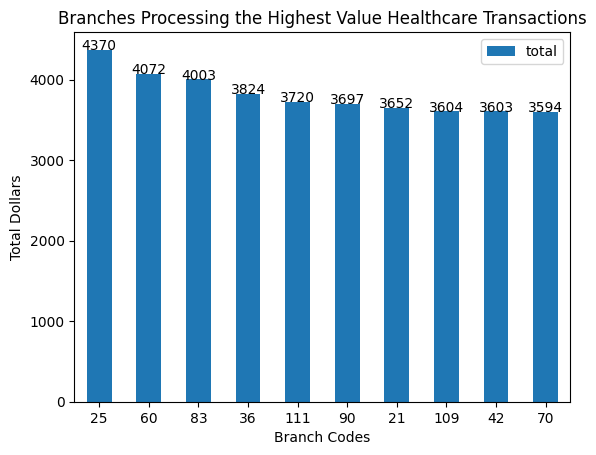

In [179]:
import matplotlib.pyplot as plt

# Assuming df_branch_highest_healthcare has duplicates and you want to remove them
df_branch_highest_healthcare = df_branch_highest_healthcare.drop_duplicates()

# Plot the cleaned DataFrame
ax = df_branch_highest_healthcare.plot(kind="bar", x='BRANCH_CODE', y='total')
plt.title("Branches Processing the Highest Value Healthcare Transactions")
plt.xlabel("Branch Codes")
plt.ylabel("Total Dollars")

# Set the x-tick labels to branch codes
ax.set_xticklabels(df_branch_highest_healthcare['BRANCH_CODE'])

plt.xticks(rotation=0)
addlabels(df_branch_highest_healthcare.index, df_branch_highest_healthcare["total"].round().astype(int))
plt.show()
